# <center>Armis : Click Prediction Case</center>
<center>Quentin LIANCE</center>

# Table of Contents

* [Presentation](#Presentation)
* [Exploratory Data Analysis](#Exploratory_Data_Analysis)
    * [Variables glossary](#0.0)
    * [Event](#1.0)
    * [Creative shape - width & height](#1.1)
    * [Creative shape x Media cost dollars CPM](#1.2)
    * [Fold position](#1.3)
    * [Media cost dollars CPM](#1.4)
    * [Date](#1.5)
    * [Browser](#1.6)
    * [Operating system](#1.7)
    * [Geo DMA](#1.8)
    * [Device ID](#1.9)
    * [Domain site](#1.10)
    * [Mobile app instance ID](#1.11)
    * [Advertiser ID](#1.12)
    * [Creative ID](#1.13)
    * [Carrier ID](#1.14)
    * [New publisher ID](#1.15)
* [Summary](#Summary)

# Presentation <a class="anchor" id="Presentation"></a>

In online advertising, click-through rate (CTR) is a very important metric for evaluating ad performance. As a result, click prediction systems are essential and widely used for sponsored search and real-time bidding.

In 2015, $52.8 billion will be spent in digital advertising in the U.S., accounting for 30\% of the overall advertising expenses. This is a 13\% increase since last year, and about 5 times more than 2005. One of the keys to digital advertising’s success lies among its ability to target consumers efficiently. Using the history of queries and navigation, the publishers (Google, Bing...) can predict which ads match the most to the user and publish them accordingly.

One key predictor of interest for this task is the click-through rate probability, i.e. __the probability
that the user clicks on the ad.__

For this case, we have provided 7 days worth of Armis data to build and test prediction models.
The dataset is composed of impression and click events. __Thus, a click event necessary
happens after an impression even.__ For a better understanding of how the online advertising
works, please find below some key explanations:

An ad impression is counted when an ad is displayed. A click is counted when a displayed ad is
clicked
* __CPM__ = Cost per mil. cost in € of 1000 ad impressions
* __CPC__ = Cost per click. cost in € of one click
* __CTR__ = Click-through rate (number of clicks / number of impressions)

# Exploratory data analysis <a class="anchor" id="Exploratory_Data_Analysis"></a>

Let's discover the composition of our dataset :

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from scipy.stats import chi2_contingency
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
# Read the csv into pandas DataFrame
df = pd.read_csv('train.csv')

# Display the shape of dataframe (number of rows and columns)
print("df shape : {}".format(df.shape))

# Display the first three rows, and then transpose them to see all columns
df.head(3).T

df shape : (5102803, 19)


,0,1,2
creative_width,300,728,300
creative_height,250,90,250
fold_position,0,0,0
media_cost_dollars_cpm,0.20832,1.81133,0.12825
operating_system,176,156,170
browser,8,8,21
mobile_app_instance_id,0,0,0
advertiser_id,1872690,3911298,1872690
creative_id,180101490,182813818,181226109
carrier_id,1,198,1


## Variables glossary <a class="anchor" id="0.0"></a>

Here __the definition of each variable :__ 

* __new_auction_id_64__ : id of an event
* __creative_witdh__ : The width of the creative 
* __creative_height__ : The height of the creative 
* __fold_position__ : The placement position relative to fold. Possible values : 0 = Unknown, 1 = Above, 2 = Below 
* __media_cost_dollars_cpm__ : The amount in USD x 1000 that Armis pays for an impression 
* __operating_system__ : The ID of operating system version 
* __browser__ : The ID for the publisher of the placement 
* __new_publisher_id__ : The ID for the publisher of the placement 
* __new_site_domain__ : The most granular identifier of the site that Armis can access 
* __mobile_app_instance_id__ : Specifies the ID of the mobile app instance for this impression 
* __advertiser_id__ : the ID of the advertiser 
* __creative_id__ : the ID of the creative 
* __carrier_id__ : the ID of the carrier associated with the mobile device 
* __device_id__ : The model ID of the mobile device 
* __geo_dma__ : geo info 
* __dates__ : year, month, day 
* __event__ : 1 for event of a click, 0 for event of impression 

Here we will deal with a __supervised classification problem__, where `event` is our variable of interest : whether an advertisement was clicked or not. We want to derive, for each ad, __the probability that the ad was clicked__.

## Event <a class="anchor" id="1.0"></a>

In [3]:
pd.DataFrame({"Count" : df["event"].value_counts(),
              "Proportion" : df["event"].value_counts(normalize=True).mul(100)})

,Count,Proportion
0,5098871,99.922944
1,3932,0.077056


The dataset is highly imbalanced : __less than 1% of events__ are __events of a click__ (1), while __more than 99% of events__ are __events of impression__ (0). This approx. 0.08% corresponds to the __overall click through rate, or CTR__.

Before going further, we will create a __test set__ following the wise advice of Aurélien Géron in his book *Hands-On Machine Learning with Scikit-Learn and TensorFlow :* 

> It may sound strange to voluntarily set aside part of the data at this stage. After all, we have only taken a quick glance at the data, and surely we should learn a whole lot more about it before you decide what algorithms to use. This is true, but our brain is an amazing pattern detection system, which means that it is highly prone to overfitting : if you look at the test set, you may stumble upon some seemingly interesting pattern in the test data that leads you to select a particular kind of Machine Learning model. When you estimate the generalization error using the test set, your estimate will be too optimistic, and you will launch a system that will not perform as well as expected. This is called data snooping bias.

We want to keep the same proportion of `event` in our train set and test set. To do so, we can use the method `StratifiedShuffleSplit` provided by sklearn : 

In [4]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["event"]) :
    strat_train = df.loc[train_index]
    strat_test = df.loc[test_index]

As we won't use `strat_test` in this notebook, we will rename `strat_train` with a more convenient name :

In [5]:
df = strat_train.copy().reset_index()

## Creative shape - width & height <a class="anchor" id="1.1"></a>

In [6]:
df[['creative_width', 'creative_height']].head(3)

,creative_width,creative_height
0,728,90
1,320,50
2,728,90


These numbers corresponds to __the dimension of the creatives in terms of pixels.__ Let's create a new variable called `creative_shape` corresponding to __the shape of the creative :__

In [7]:
df['creative_shape'] = df['creative_width'].astype(str) + " x " + df['creative_height'].astype(str)
df[['creative_width', 'creative_height', 'creative_shape']].head(3)

,creative_width,creative_height,creative_shape
0,728,90,728 x 90
1,320,50,320 x 50
2,728,90,728 x 90


In [8]:
def get_countplot(feature, title, data) :
    
    '''Function to get ordered countplot for a categorical variable.
    
    Parameters 
    ----------
    feature : string
        the categorical variable we want to represent
    title : string
        the title we want to add to the graph
    data : pandas dataframe
        the dataframe where the data are stored
    
    Returns 
    -------
    A horizontal seaborn countplot of our variable of interest (feature), ordered by frequency.
    '''
    
    plt.figure(figsize=(8,4))
    sns.countplot(y=feature, data=data, palette="Blues_r", order = data[feature].value_counts().index)
    plt.xticks(fontsize=13) ; plt.yticks(fontsize=13)
    plt.ylabel(feature, fontsize=17) ; plt.xlabel("count",fontsize=17)
    plt.title(title, fontsize=18)
    plt.show()

The following bar plot counts __the number of ads where users clicked on for each type of creative shape :__

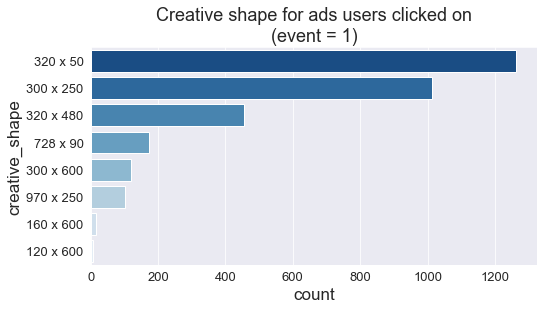

In [9]:
# only for click events
get_countplot("creative_shape",
              "Creative shape for ads users clicked on\n(event = 1)",
              data=df[df["event"] == 1])

And this one counts __the number of ads where users didn't click on for each type of creative shape :__

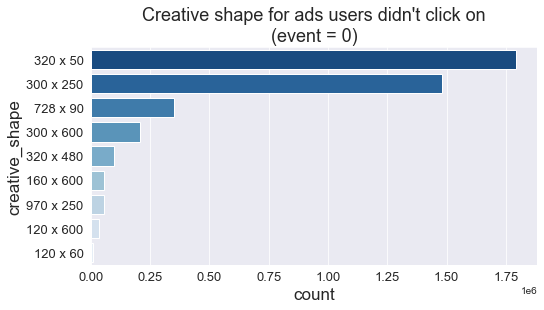

In [10]:
# only for impression events
get_countplot("creative_shape",
              "Creative shape for ads users didn't click on\n(event = 0)",
              data = df[df["event"] == 0])

__Assumption :__ There is a statistically significant relationship betweeen __the shape of a creative__ and __the fact of clicking or not.__

Let's make a __Chi-square test__ of independence of variables in a __contingency table.__ The idea is the following : if a explanatory variable seems to be linked (= not independant) to our target variable according to this test, __then the variable will probably be useful to predict whether an ad is clicked or not.__

We write a little function for this as we will reproduce this test several times :

In [11]:
def chi_square_test(feature) :
    '''
       Chi-square test of independence of variables in a contingency table. 
    
       This function computes the chi-square statistic and p-value for the hypothesis test of
       independence of the observed frequencies in the contingency table observed.
       
       Parameters
       ----------
       feature : string
           The categorical feature we want to associate with the variable "event" in the contingency table
           
       Returns
       -------
       The result of the hypothesis test depending on the p-value obtained. 
    '''
    
    g, p, _, _ = chi2_contingency(pd.crosstab(df["event"], df[feature]).fillna('missing'))
    if p <= 0.05 :
        print("Null hypothesis rejected : The nature of the event and " + feature + " are not independant.")
    else : 
        print("We cannot reject the null hypothesis : The nature of the event and " + feature + " seems to be independant.")

In [12]:
chi_square_test("creative_shape")

Null hypothesis rejected : The nature of the event and creative_shape are not independant.


`creative_shape` might be a good feature to predict whether an ad was clicked or not. __We can represent, for each category of event (clicks VS impressions), the proportion of each kind of creative shape :__

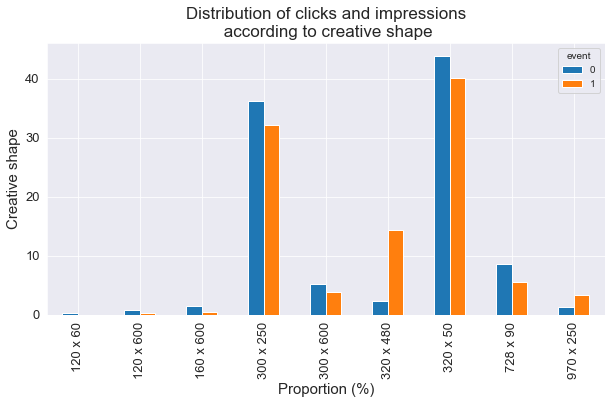

In [13]:
table = pd.crosstab(df["event"], df['creative_shape'], normalize="index").mul(100).T.reset_index()
table.plot(x="creative_shape", y=[0,1], kind="bar", figsize=(10,5))
plt.xticks(fontsize=13) ; plt.yticks(fontsize=13)
plt.ylabel("Creative shape", fontsize=15) , plt.xlabel("Proportion (%)", fontsize=15)
plt.title("Distribution of clicks and impressions\n according to creative shape", fontsize=17)
plt.show()

In [14]:
pd.crosstab(df["event"], df['creative_shape'], normalize="index").mul(100)

creative_shape,120 x 60,120 x 600,160 x 600,300 x 250,300 x 600,320 x 480,320 x 50,728 x 90,970 x 250
event,,,,,,,,,
0,0.195803,0.832096,1.391411,36.284682,5.110912,2.368539,43.926669,8.554077,1.335811
1,0.000000,0.190718,0.508582,32.199619,3.814367,14.431024,40.114431,5.467260,3.273999


For both category of event (impression or click), the majority of the creative shape is `320x50`. But we can see an interesting gap concerting event with creative of shape `320x480` : __14%__ of event of click (`event = 1`) contains creative with shape `320x480`, whereas only 2% of event of impression contains this kind of creative, which is not negligible as this creative shape is the third most clickable (after `320x50` and `300x250`).

To get the __CTR according the the creative shape__, we write a function that shows the click through rate among each category of a categorical feature : 

In [15]:
def get_CTR(feature, end_of_title) : 
    
    '''
    Function to get the Click through rate for a categorical feature
    
    Parameters
    ----------
    feature : string
        the name of the categorical feature
    end_of_title : string
        the end of the title associated with the bar plot
        
    Returns
    -------
    A barplot giving CTR for each category of the categorical feature 
    '''
    
    df.groupby(feature)['event'].mean().mul(100).sort_values(ascending = True).plot(kind='barh', figsize=(8,4))
    plt.xticks(fontsize=13) ; plt.yticks(fontsize=13)
    plt.ylabel(feature, fontsize=15) ; plt.xlabel("CTR (%)", fontsize=15)
    plt.title("Click through rate (CTR) according to " + end_of_title, fontsize=17)
    plt.show()

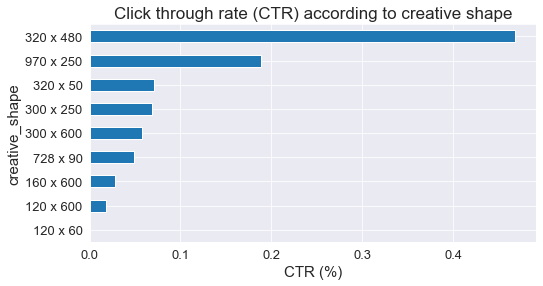

In [16]:
get_CTR("creative_shape", "creative shape")

## Creative shape x Media cost dollars CPM <a class="anchor" id="1.2"></a>

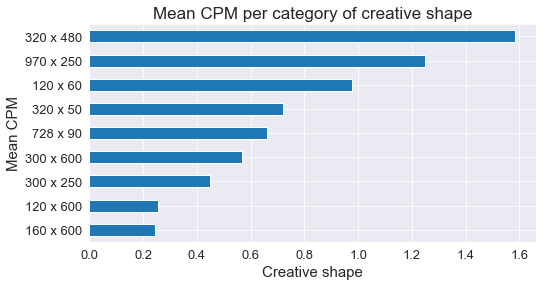

In [17]:
# Mean CPM for each category of creative shape
df.groupby('creative_shape')['media_cost_dollars_cpm'].mean().sort_values(ascending = True).\
plot(kind='barh', figsize=(8,4))
plt.xticks(fontsize=13) ; plt.yticks(fontsize=13)
plt.xlabel("Creative shape", fontsize=15) , plt.ylabel("Mean CPM", fontsize=15)
plt.title("Mean CPM per category of creative shape", fontsize=17)
plt.show()

The two categories of creative shape with the highest mean CPM are `320x480` and `970x250`, which exactly corresponds to the two categories with the highest CTR. Interesting interactions !

## Fold position <a class="anchor" id="1.3"></a>

In [18]:
df["fold_position"] = df["fold_position"].map({0:'Unknown',1:'Above',2:'Below'})
pd.crosstab(df["event"], df["fold_position"], normalize="index").mul(100)

fold_position,Above,Below,Unknown
event,,,
0,24.326199,10.352612,65.321189
1,19.357915,1.843611,78.798474


In [19]:
chi_square_test("fold_position")

Null hypothesis rejected : The nature of the event and fold_position are not independant.


Respectively __79%__ (65%) of __ads users clicked on__ (we didn't click on) __had an unknown placement position relative to fold.__ We will consider this lack of information as __an information by itself__. Moreover, respectively 2% (10%) of ads we clicked on (we didn't click on) had a position below the fold. __So users seems to be less attracted by ad with this position.__

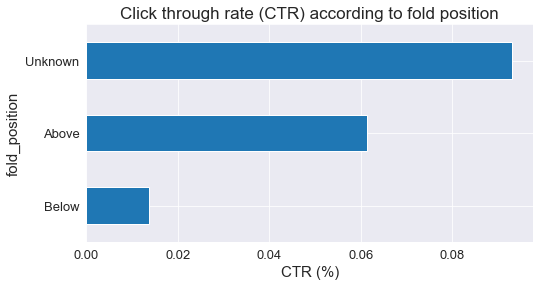

In [20]:
get_CTR("fold_position", "fold position")

## Media cost dollars CPM <a class="anchor" id="1.4"></a>

Let's represent the distribution of media cost dollars CPM for each category of event (whether users clicked on or not) :

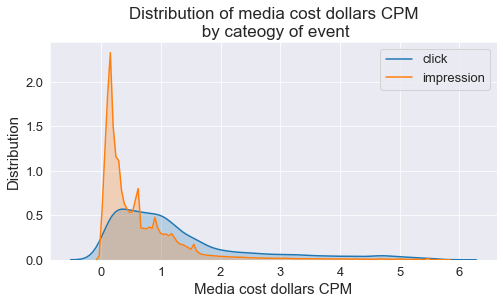

In [21]:
plt.figure(figsize=(8,4))
sns.kdeplot(df[df["event"] == 1]['media_cost_dollars_cpm'], label = "click", shade=True)
sns.kdeplot(df[df["event"] == 0]['media_cost_dollars_cpm'], label = "impression", shade=True)
plt.title("Distribution of media cost dollars CPM\n by cateogy of event", fontsize=17)
plt.xticks(fontsize=13), plt.xlabel("Media cost dollars CPM", fontsize=15)
plt.yticks(fontsize=13), plt.ylabel("Distribution", fontsize=15)
plt.legend(fontsize=13)
plt.show()

Despite the overlap of the two distributions, we are able to see that __CPM for ads we clicked on tends to be slightly higher than CPM for ads we didn't click on.__ Let's see some descriptive statistics to go further : 

In [22]:
df.groupby('event')['media_cost_dollars_cpm'].agg(['count','mean','median','min','max','std'])

,count,mean,median,min,max,std
event,,,,,,
0,4079096,0.626398,0.36194,0.00000,5.76404,0.742976
1,3146,1.271170,0.91618,0.01244,5.75683,1.188613


* The mean CPM is __twice greater__ for ads users clicked on than for ads where users didn't click. 
* The median CPM is almost __3 times greater__ for ads users clicked on than for ads users didn't click on.

Let's discretize the continous variable `media_cost_dollars_cpm` into __4 categories__ with the same proportion of ads into each category :

In [23]:
df["cpm_cat"] = pd.qcut(df['media_cost_dollars_cpm'], 4)
df["cpm_cat"].value_counts(normalize=True).sort_index()

(-0.001, 0.158]    0.250017
(0.158, 0.362]     0.249989
(0.362, 0.854]     0.249995
(0.854, 5.764]     0.250000
Name: cpm_cat, dtype: float64

As we have discretized the `media_cost_dollars_cpm` feature, we now be able to apply a __chi square test on it :__

In [24]:
chi_square_test("cpm_cat")

Null hypothesis rejected : The nature of the event and cpm_cat are not independant.


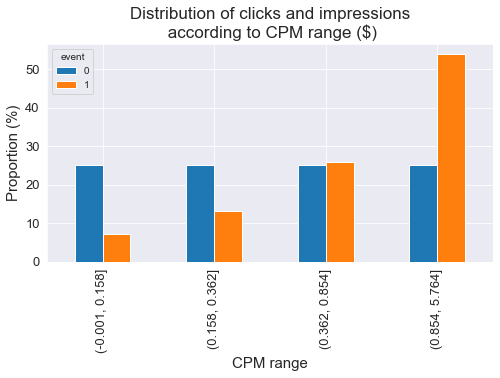

In [25]:
table = pd.crosstab(df["event"], df['cpm_cat'], normalize="index").mul(100).T.reset_index()
table.plot(x="cpm_cat", y=[0,1], kind="bar", figsize=(8,4))
plt.xticks(fontsize=13) ; plt.yticks(fontsize=13)
plt.xlabel("CPM range", fontsize=15) , plt.ylabel("Proportion (%)", fontsize=15)
plt.title("Distribution of clicks and impressions\n according to CPM range ($)", fontsize=17)
plt.show()

In [26]:
pd.crosstab(df.event, df.cpm_cat, normalize='index').mul(100)

cpm_cat,"(-0.001, 0.158]","(0.158, 0.362]","(0.362, 0.854]","(0.854, 5.764]"
event,,,,
0,25.015420,25.008016,24.998799,24.977765
1,7.151939,13.159568,25.905912,53.782581


More than half of the ads users clicked have a CPM greater of equal than 0.854 $

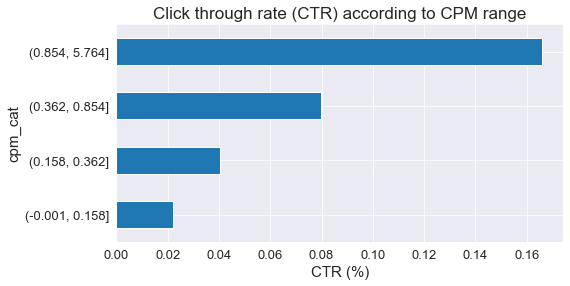

In [27]:
get_CTR("cpm_cat", "CPM range")

__Users definitely tend to click on ads with a higher CPM.__

## Date <a class="anchor" id="1.5"></a>

First, let's create a variable `date` based on `year`,`month` and `day` :

In [28]:
df["date"] = pd.to_datetime(df[['year', 'month', 'day']])
df["date"].value_counts(normalize=True).mul(100).sort_index()

2019-10-01     9.344399
2019-10-02    11.976115
2019-10-03    13.876051
2019-10-04    14.838831
2019-10-05    16.637769
2019-10-06    14.607537
2019-10-07    18.719297
Name: date, dtype: float64

In [29]:
chi_square_test("date")

Null hypothesis rejected : The nature of the event and date are not independant.


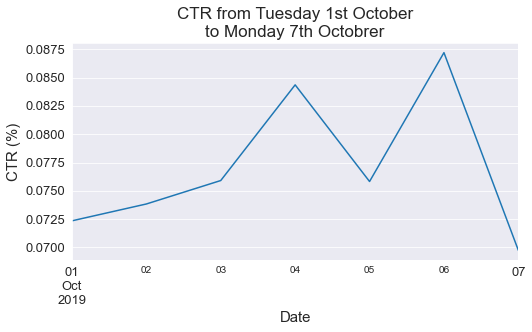

In [30]:
df.groupby('date')['event'].mean().mul(100).plot(figsize=(8,4))
plt.xlabel("Date",fontsize=15) ; plt.ylabel("CTR (%)", fontsize=15)
plt.xticks(fontsize=13) ; plt.yticks(fontsize=13)
plt.title("CTR from Tuesday 1st October\nto Monday 7th Octobrer", fontsize=17)
plt.show()

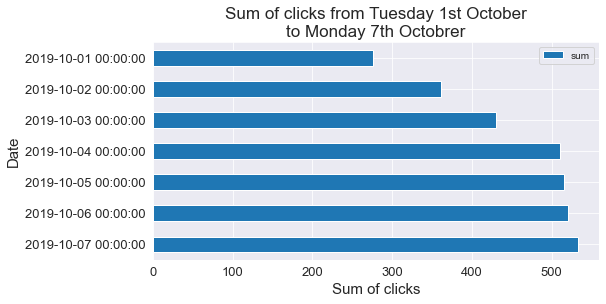

In [31]:
df.groupby('date')['event'].agg({'sum'}).sort_values('sum', ascending=False).plot(kind="barh", figsize=(8,4))
plt.ylabel("Date",fontsize=15) ; plt.xlabel("Sum of clicks", fontsize=15)
plt.xticks(fontsize=13) ; plt.yticks(fontsize=13)
plt.title("Sum of clicks from Tuesday 1st October\nto Monday 7th Octobrer", fontsize=17)
plt.show()

We can see that between Tuesday (`2019-10-01`) and Thursday (`2019-10-03`), the click through rate were lower than 0.08%. __But we are able to highlight two spikes :__ Friday (`2019-10-04`) and Sunday (`2019-10-06`), where the CTR became greater than 0.08%. So we can create a __dummy variable__ taking the value __1 if the ad were published friday or sunday, and 0 otherwise.__ Alternatively, we can create a dummy variable taking the value 1 if the ad were published between friday and monday (when the daily sum of clicks were greater than 500), and 0 otherwise.

## Browser <a class="anchor" id="1.6"></a>

In [32]:
print("There are {} different browsers.".format(df["browser"].nunique()))
chi_square_test("browser")

There are 21 different browsers.
We cannot reject the null hypothesis : The nature of the event and browser seems to be independant.


__We won't use browser as explanatory variable,__ but we can see by curiously the CTR for each browser : 

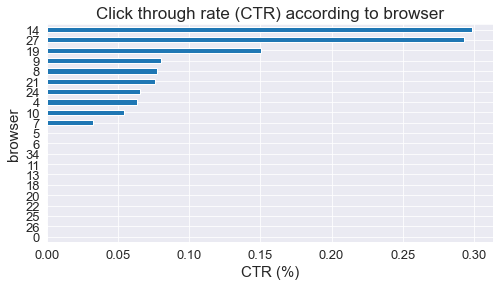

In [33]:
get_CTR("browser", "browser")

## Operating system<a class="anchor" id="1.7"></a>

For several categorial variable, __we have hundreds or even thousands of different categories, which could be problematic for modelling.__ To partially handle this issue, one possible strategy is __to gather the rarest categories into a single one called `Rare` for example.__ 

But how to determine how many categories we want to keep, and how many categories we want to gather ? The following function `get_cdf` help us to take that decision. 

Let's take the example of the variable `operating_system` :

In [34]:
def get_cdf(variable):
    '''
    To get the cumulative distribution function (CDF) of the frequence of a categorical variable,
    from the most frequent category to the less frequent one. 
    
    Parameters 
    ----------
    variable : string
        The variable we want to see in terms of frequency
        
    Returns
    -------
        A plot with the cumulative distribution with four quantiles : 25th, 50th, 75th and 90th. 
    '''
    
    values = df[variable].value_counts(normalize=True).values
    y = 100 * np.cumsum(values)
    x = np.arange(0,len(y))
    
    q_25 = np.argmax(y > 25) + 1
    q_50 = np.argmax(y > 50) + 1
    q_75 = np.argmax(y > 75) + 1
    q_90 = np.argmax(y > 90) + 1
    
    plt.figure(figsize=(8,4))
    plt.ylabel("CDF (%)", fontsize=15) ; plt.xlabel(variable, fontsize=15)
    plt.title("Cumulative distribution function", fontsize=18)
    plt.plot(x, y, label= "25%: {}\n50%: {}\n75%: {}\n90%: {}".format(q_25,q_50,q_75,q_90))
    plt.xticks(fontsize=13) ; plt.yticks(fontsize=13)
    plt.legend(fontsize=13, loc="lower right")
    plt.show()

There are 116 different categories into the operating_system variable.


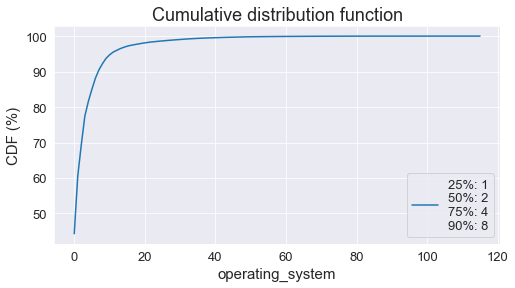

In [35]:
print("There are {} different categories into the operating_system variable.".format(df.operating_system.nunique()))
get_cdf("operating_system")

The 8 most frequent OSes represent 90% of all OS used. So we can keep only these 8 most frequent categories, and gather the 108 (116 - 8) less frequent ones into one category `Rare`. 

## Geo DMA <a class="anchor" id="1.8"></a>

There are 68 differents geo_dma.


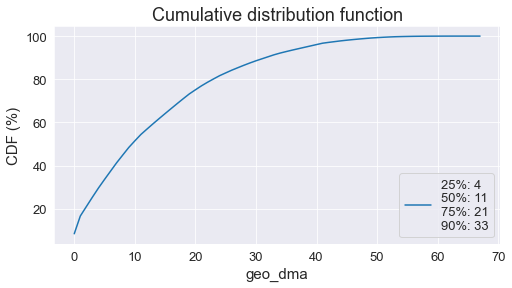

In [36]:
print("There are {} differents geo_dma.".format(df['geo_dma'].nunique()))
get_cdf("geo_dma")

For `geo_dma`, we will keep only the 33 most frequent categories of geo_dma.

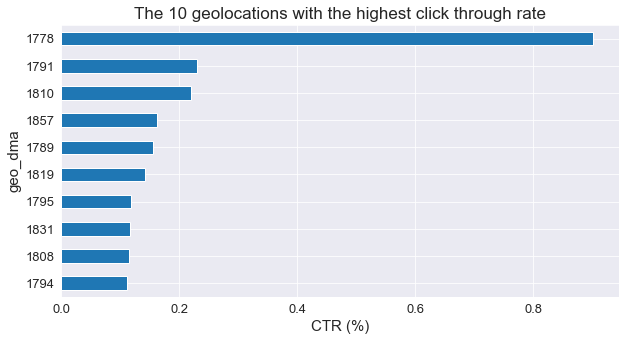

In [37]:
df.groupby("geo_dma")['event'].mean().mul(100).sort_values(ascending=True).\
tail(10).plot(kind="barh", figsize=(10,5))
plt.title("The 10 geolocations with the highest click through rate", fontsize=17)
plt.xlabel("CTR (%)",fontsize=15) ; plt.ylabel("geo_dma", fontsize=15)
plt.xticks(fontsize=13) ; plt.yticks(fontsize=13)
plt.show()

## Device ID <a class="anchor" id="1.9"></a>

There are 1682 differents device ID.


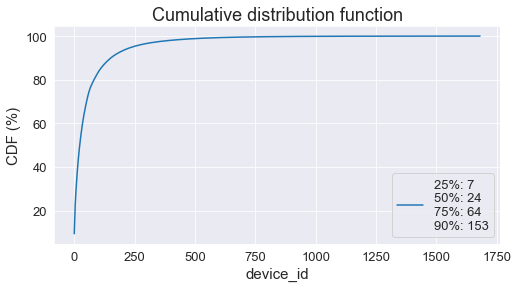

In [38]:
print("There are {} differents device ID.".format(df['device_id'].nunique()))
get_cdf("device_id")

For `device_id`, __we will keep only the 153 most frequent categories of device ID.__

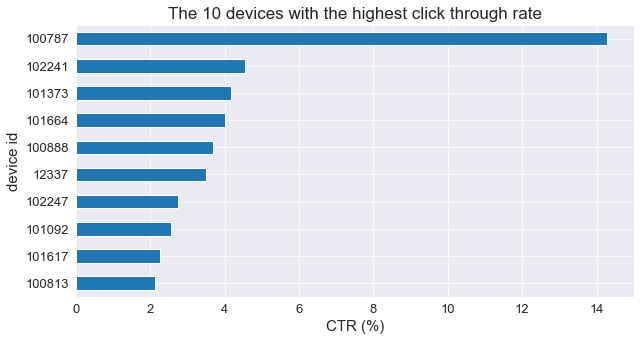

In [39]:
df.groupby("device_id")['event'].mean().mul(100).sort_values(ascending=True).\
tail(10).plot(kind="barh", figsize=(10,5))
plt.title("The 10 devices with the highest click through rate", fontsize=17)
plt.xlabel("CTR (%)",fontsize=15) ; plt.ylabel("device id", fontsize=15)
plt.xticks(fontsize=13) ; plt.yticks(fontsize=13)
plt.show()

## Domain site <a class="anchor" id="1.10"></a>

There are 13544 differents domain sites.


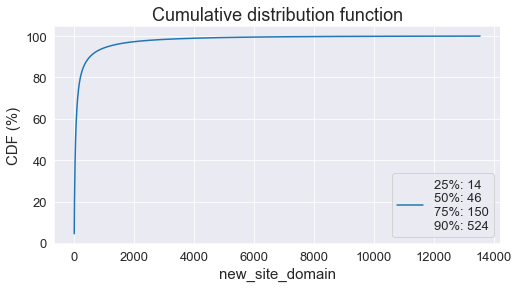

In [40]:
print("There are {} differents domain sites.".format(df['new_site_domain'].nunique()))
get_cdf("new_site_domain")

The 524 most frequent domain sites represent 90% of all the sites in the database

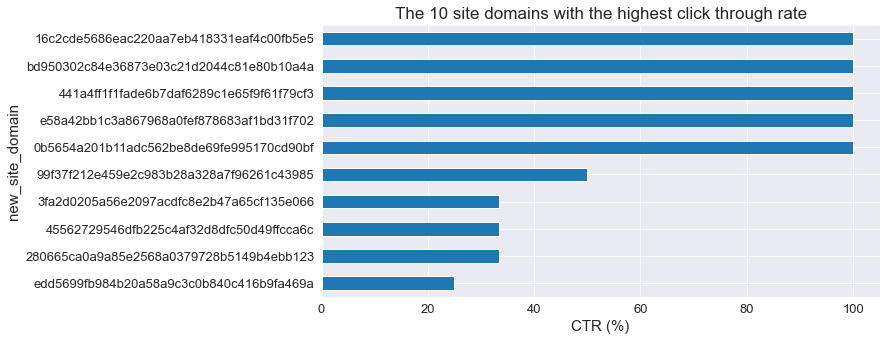

In [41]:
df.groupby("new_site_domain")['event'].mean().mul(100).sort_values(ascending=True).\
tail(10).plot(kind="barh", figsize=(10,5))
plt.title("The 10 site domains with the highest click through rate", fontsize=17)
plt.xlabel("CTR (%)",fontsize=15) ; plt.ylabel("new_site_domain", fontsize=15)
plt.xticks(fontsize=13) ; plt.yticks(fontsize=13)
plt.show()

## Mobile app instance ID <a class="anchor" id="1.11"></a>

In [42]:
pd.crosstab(df["event"], df["mobile_app_instance_id"].fillna("missing"), normalize='index')

mobile_app_instance_id,0.0,missing
event,,
0,0.989136,0.010864
1,0.991736,0.008264


In [43]:
chi_square_test("mobile_app_instance_id")

We cannot reject the null hypothesis : The nature of the event and mobile_app_instance_id seems to be independant.


## Advertiser ID <a class="anchor" id="1.12"></a>

In [44]:
print("There are {} differents advertiser_id.".format(df['advertiser_id'].nunique()))
pd.crosstab(df["event"], df["advertiser_id"], normalize='index').mul(100)

There are 4 differents advertiser_id.


advertiser_id,1872690,2040640,2078681,3911298
event,,,,
0,47.368951,11.739881,31.211597,9.679571
1,54.227591,10.966306,25.333757,9.472346


In [45]:
chi_square_test("advertiser_id")

Null hypothesis rejected : The nature of the event and advertiser_id are not independant.


We can see a significant difference of composition for two advertisers : `1872690` and `2078681` : Respectively __54%__ (47%) __of ads we clicked on__ (we didn't click on) __came from the advertiser `1872690`__. On the opposite, __25%__ (31%) __of ads we clicked on__ (we didn't click on) __came from the advertiser `2078681`__. We can conclude that the first advertiser seems to be relatively more efficent to provide adds we clicked on, whereas the second advertiser seems to be relatively less efficient.

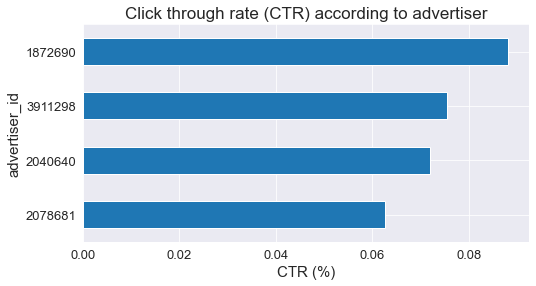

In [46]:
get_CTR("advertiser_id", "advertiser")

## Creative ID <a class="anchor" id="1.13"></a>

There are 195 differents creative_id.


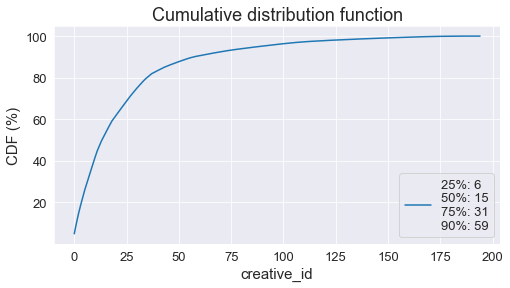

In [47]:
print("There are {} differents creative_id.".format(df['creative_id'].nunique()))
get_cdf("creative_id")

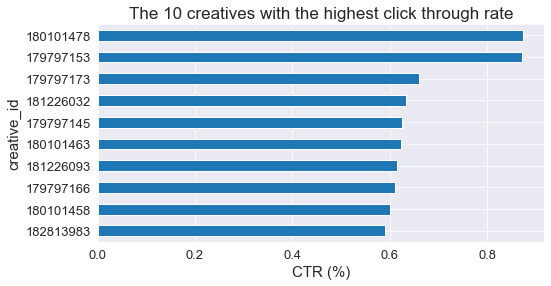

In [48]:
df.groupby("creative_id")['event'].mean().mul(100).sort_values(ascending=True).\
tail(10).plot(kind="barh", figsize=(8,4))
plt.title("The 10 creatives with the highest click through rate", fontsize=17)
plt.xlabel("CTR (%)",fontsize=15) ; plt.ylabel("creative_id", fontsize=15)
plt.xticks(fontsize=13) ; plt.yticks(fontsize=13)
plt.show()

## Carrier ID <a class="anchor" id="1.14"></a>

There are 19 differents carrier_id.


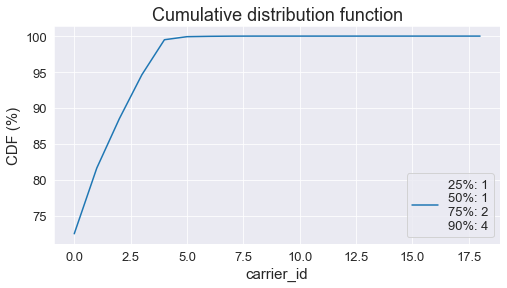

In [49]:
print("There are {} differents carrier_id.".format(df['carrier_id'].nunique()))
get_cdf("carrier_id")

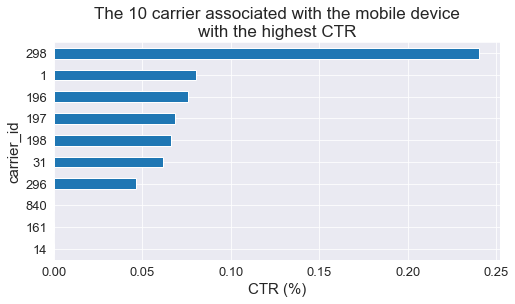

In [50]:
df.groupby("carrier_id")['event'].mean().mul(100).sort_values(ascending=True).\
tail(10).plot(kind="barh", figsize=(8,4))
plt.title("The 10 carrier associated with the mobile device\nwith the highest CTR", fontsize=17)
plt.xlabel("CTR (%)",fontsize=15) ; plt.ylabel("carrier_id", fontsize=15)
plt.xticks(fontsize=13) ; plt.yticks(fontsize=13)
plt.show()

## New publisher ID <a class="anchor" id="1.15"></a>

There are 7363 differents new_publisher_id.


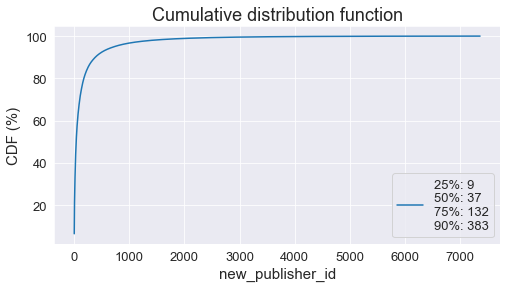

In [51]:
print("There are {} differents new_publisher_id.".format(df['new_publisher_id'].nunique()))
get_cdf("new_publisher_id")

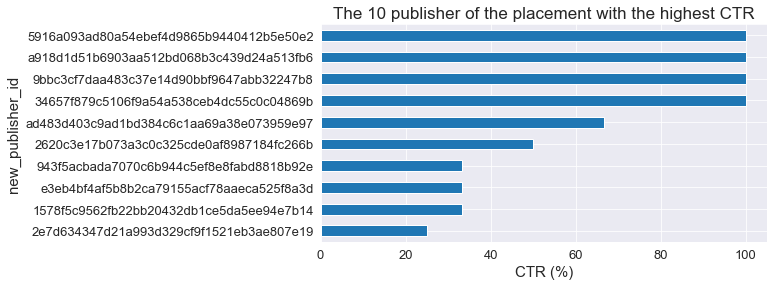

In [52]:
df.groupby("new_publisher_id")['event'].mean().mul(100).sort_values(ascending=True).\
tail(10).plot(kind="barh", figsize=(8,4))
plt.title("The 10 publisher of the placement with the highest CTR", fontsize=17)
plt.xlabel("CTR (%)",fontsize=15) ; plt.ylabel("new_publisher_id", fontsize=15)
plt.xticks(fontsize=13) ; plt.yticks(fontsize=13)
plt.show()

# Summary <a class="anchor" id="Summary"></a>

* The dataset is highly imbalanced (more than 99,9% of impressions, less than 0.01% of events)

* The overall click through rate (CTR) corresponds to the proportion of event of click - here less than 0.01%

* Creatives with shape `320x480` benefit from the highest click through rate (around 0.45%), followed by creatives with shape `970x250`

* Ads with the highest CTR had an unknown position relative to fold, and those with the lowest CTR were located below the fold

* Users seem to be more attracted by ads with highest cost per mile (CPM)

* Some categories of features with high cardinality benefit from tremendous CTR, but it is due to number of few number of impressions : as CTR corresponds to the number of click-throughs divided by the the number of impressions, if we have only one impression on which a user click, then the CTR is equal to 1

* We will use *creative_height* and *creative_width* through our new feature `creative_shape`

* We will use *media_cost_dollars* through our new feature `cpm_cat`

* We will use *day, month, year* through our new feature `from_friday_to_monday` or `friday_or_sunday`

* We will reduce features with high cardinality to their most frequent category, and gather the less frequent ones 

* We won't use `browser` and `mobile_app_instance_id`